In [69]:
# Import phase if every import is here it is to allow you to run this cell and know if you have any issue and not after a few hours of training

import tensorflow
from tensorflow import keras
import os
import numpy as np
import librosa

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt


from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Activation, Flatten, MaxPooling1D, BatchNormalization, LSTM, GaussianNoise
from tensorflow.keras.models import Sequential


from src.VoiceModule import VoiceModule
from src.classifiers.KerasClassifier import KerasClassifier
from prepare_data_utils import load_wav, preprare_wav, split_sample


In [50]:
# print environment
folder_path = "../../data/keywords"
for l in os.listdir(folder_path):
    print(l)

down
tree
_background_noise_
go
house
validation_list.txt
eight
up
bed
two
dog
no
bird
five
marvin
seven
four
visual
happy
nine
data_speech_commands_v0.02.tar.gz
off
yes
forward
follow
README.md
cat
three
on
right
backward
testing_list.txt
sheila
wow
.DS_Store
stop
one
zero
six
learn
LICENSE
left


In [51]:
# Transform data method

def mfcc(buffer, samplerate, dim):
    a = librosa.feature.mfcc(y=buffer, sr=samplerate, n_mfcc=dim)
    a = np.transpose(a)
    return a


In [52]:
# Create callback to later draw some graphs

class PerformanceLogger(Callback):
    def __init__(self):
        # List of tuple (loss, accuracy)
        self.training = []
        self.testing = []
    def on_epoch_end(self, epoch, logs=None):
        self.training.append((logs["loss"], logs["acc"]))
        self.testing.append((logs["val_loss"], logs["val_acc"]))

In [65]:
# This function prints metrics about a model
def print_metrics(X, Y, label_name_list, voice_module):
    Y_pred = voice_module.model._model.predict(X)
    Y_pred = np.argmax(Y_pred, axis=1)
    Y_max = np.argmax(Y, axis=1)
    print(confusion_matrix(Y_max, Y_pred))
    print(classification_report(Y_max, Y_pred, target_names=label_name_list))

In [56]:
# Create class
class KeywordClassifierCnn(KerasClassifier):
    def __init__(self, file_path=None):
        super().__init__(file_path)

    def predict(self, x):
        x = np.expand_dims(np.array([x]), axis=2)
        return self._model.predict(x)

    def build(self):
        model = Sequential()
        # Adding noise to the training data
        model.add(GaussianNoise(0.2))
        
        # feature Extraction layers
        model.add(BatchNormalization())
        model.add(Conv1D(256, 3, input_shape=(50, 13), padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Conv1D(128, 3, input_shape=(50, 13), padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Conv1D(64, 3, input_shape=(50, 13), padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Conv1D(64, 3, input_shape=(50, 13), padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=2))
        
        # End of the neuron and classification part
        model.add(Dropout(0.4))
        model.add(Flatten())
        model.add(BatchNormalization())
        model.add(Dense(128))
        model.add(Dense(35))
        model.add(Activation('softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        self._model = model
        
    def train(self, X, Y, batch_size=32, epoch=720, validation_data=None, callbacks=[]):
        self._model.fit(X, Y, batch_size=batch_size, epochs=epoch, validation_data=validation_data, callbacks=callbacks)

    def transform(self, x, samplerate):
        to_process = mfcc(x, samplerate, 13)
        to_process = pad_sequences([to_process], maxlen=35, padding='post')[0]
        return to_process


In [58]:
#Instanciate model
digit_list = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]
keyword_list = ["backward", "bed", "bird", "cat", "dog", "down", "follow", "forward",
               "go", "happy", "house", "learn", "left", "marvin", "no", "off", "on",
               "right", "sheila", "stop", "tree", "up", "visual", "wow", "yes"] + digit_list
print(len(keyword_list))
dimension_mfcc = 13
samplerate = 16000
nb_break=None
sample_duration=1
step=1

logger = PerformanceLogger()

cls = KeywordClassifierCnn()
vm = VoiceModule("digit", keyword_list, cls)

35


In [59]:
# Prepare data for training
data = {f: load_wav(f"{folder_path}/{f}", nb_break) for f in keyword_list}
X, Y = preprare_wav(data, vm, sample_duration, step)
print("Done", X.shape)

Doing backward
Doing bed
Doing bird
Doing cat
Doing dog
Doing down
Doing follow
Doing forward
Doing go
Doing happy
Doing house
Doing learn
Doing left
Doing marvin
Doing no
Doing off
Doing on
Doing right
Doing sheila
Doing stop
Doing tree
Doing up
Doing visual
Doing wow
Doing yes
Doing zero
Doing one
Doing two
Doing three
Doing four
Doing five
Doing six
Doing seven
Doing eight
Doing nine
Done (95394, 35, 13)


In [60]:
X_file = f"x_{'_'.join(keyword_list)}-{vm._name}.npy"
Y_file = f"y_{'_'.join(keyword_list)}.npy"

In [61]:
# Saving the prepared input data 
np.save(X_file, X)
np.save(Y_file, Y)


In [62]:
# Load data for training
X, Y = np.load(X_file), np.load(Y_file)


In [63]:
"""train_size = 80 * len(X) // 100
test_size = 20 * len(X) // 100
#X = np.expand_dims(X, axis=3)
X_train, X_test, = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]"""
X = X.astype('float32')
print(X.shape)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(len(X_train), len(X_test))

print(X[0].shape)
print( X.dtype)

(95394, 35, 13)
76315 19079
(35, 13)
float32


In [64]:
vm.model.train(X_train, Y_train, batch_size=512, epoch=100, validation_data=(X_test, Y_test), callbacks=[logger])

Train on 76315 samples, validate on 19079 samples
Epoch 1/100
76315/76315 [==============================] - 11s 145us/sample - loss: 1.8688 - acc: 0.4722 - val_loss: 1.2662 - val_acc: 0.7357
Epoch 2/100
76315/76315 [==============================] - 9s 123us/sample - loss: 0.8338 - acc: 0.7518 - val_loss: 0.6829 - val_acc: 0.8169
Epoch 3/100
76315/76315 [==============================] - 9s 121us/sample - loss: 0.6234 - acc: 0.8145 - val_loss: 0.5317 - val_acc: 0.8426
Epoch 4/100
76315/76315 [==============================] - 9s 119us/sample - loss: 0.5108 - acc: 0.8474 - val_loss: 0.3967 - val_acc: 0.8808
Epoch 5/100
76315/76315 [==============================] - 9s 118us/sample - loss: 0.4423 - acc: 0.8678 - val_loss: 0.3389 - val_acc: 0.8996
Epoch 6/100
76315/76315 [==============================] - 9s 119us/sample - loss: 0.3817 - acc: 0.8868 - val_loss: 0.3436 - val_acc: 0.8978
Epoch 7/100
76315/76315 [==============================] - 9s 119us/sample - loss: 0.3592 - acc: 0.8921

76315/76315 [==============================] - 9s 119us/sample - loss: 0.0535 - acc: 0.9829 - val_loss: 0.2705 - val_acc: 0.9438
Epoch 59/100
76315/76315 [==============================] - 9s 118us/sample - loss: 0.0476 - acc: 0.9854 - val_loss: 0.2769 - val_acc: 0.9450
Epoch 60/100
76315/76315 [==============================] - 9s 118us/sample - loss: 0.0426 - acc: 0.9866 - val_loss: 0.2835 - val_acc: 0.9438
Epoch 61/100
76315/76315 [==============================] - 9s 118us/sample - loss: 0.0420 - acc: 0.9865 - val_loss: 0.3144 - val_acc: 0.9393
Epoch 62/100
76315/76315 [==============================] - 9s 119us/sample - loss: 0.0520 - acc: 0.9836 - val_loss: 0.3118 - val_acc: 0.9416
Epoch 63/100
76315/76315 [==============================] - 9s 118us/sample - loss: 0.0940 - acc: 0.9720 - val_loss: 0.3014 - val_acc: 0.9393
Epoch 64/100
76315/76315 [==============================] - 9s 118us/sample - loss: 0.1452 - acc: 0.9587 - val_loss: 0.2570 - val_acc: 0.9421
Epoch 65/100
76315/

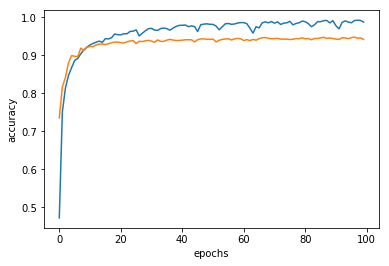

[[291   2   2 ...   1   0   0]
 [  1 321   8 ...   0   5   0]
 [  1  11 275 ...   2   0   2]
 ...
 [  1   2   2 ... 710   1   0]
 [  2   3   0 ...   2 668   1]
 [  0   2   2 ...   1   0 680]]
              precision    recall  f1-score   support

    backward       0.95      0.95      0.95       307
         bed       0.88      0.92      0.90       350
        bird       0.86      0.90      0.88       307
         cat       0.93      0.96      0.95       338
         dog       0.90      0.92      0.91       367
        down       0.93      0.94      0.93       729
      follow       0.90      0.88      0.89       290
     forward       0.91      0.89      0.90       281
          go       0.86      0.96      0.90       670
       happy       0.98      0.95      0.96       362
       house       0.99      0.94      0.96       377
       learn       0.93      0.85      0.89       281
        left       0.95      0.94      0.94       667
      marvin       0.95      0.92      0.94       3

In [70]:

plt.plot(list(range(0, len(logger.training))), list(map(lambda x:x[1], logger.training)), label="training data")
plt.plot(list(range(0, len(logger.testing))), list(map(lambda x:x[1], logger.testing)), label="testing data")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()
print_metrics(X_test, Y_test, keyword_list, vm)

In [71]:
vm.model.save("keyword-cnn.model")

In [84]:
# Create class
class EmotionClassifier(KerasClassifier):
    def __init__(self, file_path=None):
        super().__init__(file_path)

    def predict(self, x):
        x = np.expand_dims(np.array([x]), axis=2)
        return self._model.predict(x)

    def build(self):
        # Now we freeze every layer used for extracting features from data
        fine_tuned_model = Sequential(vm.model._model.layers[:-3])
        fine_tuned_model.add(Dense(128))
        fine_tuned_model.add(Dense(6))
        fine_tuned_model.add(Activation('softmax'))
        fine_tuned_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        # Here I freeze the weoghts for all layer exept the two last one
        for layer in fine_tuned_model.layers[:-9]:
            print(layer.name)
            layer.trainable = False
        fine_tuned_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])        
        self._model = fine_tuned_model

    def train(self, X, Y, batch_size=32, epoch=720, validation_data=None, callbacks=[]):
        self._model.fit(X, Y, batch_size=batch_size, epochs=epoch, validation_data=validation_data, callbacks=callbacks)

    def transform(self, x, samplerate):
        to_process = mfcc(x, samplerate, 13)
        to_process = pad_sequences([to_process], maxlen=35, padding='post')[0]
        return to_process

In [85]:
# Now we load the new dataset (savee)
emotion_list = ["calm", "happy", "angry", "fearful", "surprised", "sad"]
emotion_vm = VoiceModule("emotion", emotion_list, EmotionClassifier())
# First we change the folder path
folder_path = "../../data/savee"


gaussian_noise_6
batch_normalization_12
conv1d_24
activation_36
max_pooling1d_24
conv1d_25
activation_37
max_pooling1d_25
conv1d_26
activation_38
max_pooling1d_26


In [82]:
# Now we load the data
data = {f: load_wav(f"{folder_path}/{f}", nb_break) for f in emotion_list}
X_savee, Y_savee = preprare_wav(data, emotion_vm, sample_duration, step)
X_savee = X_savee.astype('float32')
X_savee_train, X_savee_test, Y_savee_train, Y_savee_test = train_test_split(X_savee, Y_savee, test_size=0.2, random_state=42)

Doing calm
Doing happy
Doing angry
Doing fearful
Doing surprised
Doing sad


In [86]:
emotion_vm.model.train(X_savee_train, Y_savee_train, batch_size=10, validation_data=(X_savee_test, Y_savee_test), epoch=100)

Train on 1119 samples, validate on 280 samples
Epoch 1/100
1119/1119 [==============================] - 1s 1ms/sample - loss: 2.1787 - acc: 0.2029 - val_loss: 1.8436 - val_acc: 0.1250
Epoch 2/100
1119/1119 [==============================] - 1s 693us/sample - loss: 1.9041 - acc: 0.2288 - val_loss: 1.8036 - val_acc: 0.2036
Epoch 3/100
1119/1119 [==============================] - 1s 651us/sample - loss: 1.8367 - acc: 0.2502 - val_loss: 1.7885 - val_acc: 0.2000
Epoch 4/100
1119/1119 [==============================] - 1s 674us/sample - loss: 1.8167 - acc: 0.2717 - val_loss: 1.7902 - val_acc: 0.1821
Epoch 5/100
1119/1119 [==============================] - 1s 605us/sample - loss: 1.8024 - acc: 0.2601 - val_loss: 1.8016 - val_acc: 0.2000
Epoch 6/100
1119/1119 [==============================] - 1s 617us/sample - loss: 1.8203 - acc: 0.2556 - val_loss: 1.8007 - val_acc: 0.2071
Epoch 7/100
1119/1119 [==============================] - 1s 635us/sample - loss: 1.8054 - acc: 0.2556 - val_loss: 1.7966 

1119/1119 [==============================] - 1s 949us/sample - loss: 1.6891 - acc: 0.2806 - val_loss: 1.7859 - val_acc: 0.2321
Epoch 60/100
1119/1119 [==============================] - 1s 900us/sample - loss: 1.6925 - acc: 0.2985 - val_loss: 1.7780 - val_acc: 0.2214
Epoch 61/100
1119/1119 [==============================] - 1s 798us/sample - loss: 1.6973 - acc: 0.2860 - val_loss: 1.7807 - val_acc: 0.2393
Epoch 62/100
1119/1119 [==============================] - 1s 789us/sample - loss: 1.7023 - acc: 0.2842 - val_loss: 1.7788 - val_acc: 0.2214
Epoch 63/100
1119/1119 [==============================] - 1s 796us/sample - loss: 1.7058 - acc: 0.2904 - val_loss: 1.7697 - val_acc: 0.2214
Epoch 64/100
1119/1119 [==============================] - 1s 832us/sample - loss: 1.6910 - acc: 0.3074 - val_loss: 1.7790 - val_acc: 0.2107
Epoch 65/100
1119/1119 [==============================] - 1s 880us/sample - loss: 1.7119 - acc: 0.2779 - val_loss: 1.7741 - val_acc: 0.2250
Epoch 66/100
1119/1119 [=========

In [77]:
print_metrics(X_savee_test, Y_savee_test, emotion_list, emotion_vm)

[[57  0  0  0  1 16]
 [30  0  1  0  0  7]
 [37  0  1  1  0  5]
 [34  0  0  0  0 10]
 [25  0  1  0  0 12]
 [32  0  1  0  1  8]]
              precision    recall  f1-score   support

        calm       0.27      0.77      0.39        74
       happy       0.00      0.00      0.00        38
       angry       0.25      0.02      0.04        44
     fearful       0.00      0.00      0.00        44
   surprised       0.00      0.00      0.00        38
         sad       0.14      0.19      0.16        42

    accuracy                           0.24       280
   macro avg       0.11      0.16      0.10       280
weighted avg       0.13      0.24      0.13       280

